# EDA of textual canary data

## Load necessary libraries and funtions

In [66]:
import pandas as pd
import sys
import os
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.metrics.pairwise import euclidean_distances


In [11]:
sys.path.append(
  os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader

In [17]:
loc_dict = {
    'train': '../data/raw/canary/set_B_train_kw.csv',
    'val': '../data/raw/canary/set_B_val_kw.csv',
    'test': '../data/raw/canary/set_B_test_kw.csv'
}
data_loader = DataLoader(loc_dict)

In [18]:
print(os.getcwd())

D:\Users\bergr2\PycharmProjects\ArticleClassifier\notebooks


## load training data

In [228]:
train_data_df = data_loader.load_train_data()
train_subset_df = train_data_df.iloc[:15000]

val_data_df = data_loader.load_val_data()
val_subset_df = val_data_df.iloc[:5000]

In [229]:
def get_labels(row):
    return(list(row.index[row==1]))

# print(train_data_df)
label_columns = train_subset_df.loc[:, ~train_data_df.columns.isin(['input_raw', 'input', 'pui'])]

train_subset_df['label'] = train_subset_df.apply(lambda row:get_labels(row[label_columns.columns]), axis=1)
all_label_combinations = train_subset_df['label'].to_list()

train_subset_df = train_subset_df.explode('label')
print(train_subset_df)

D:\Users\bergr2\AppData\Local\Temp\ipykernel_13136\2769983426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_subset_df['label'] = train_subset_df.apply(lambda row:get_labels(row[label_columns.columns]), axis=1)


              pui                                          input_raw  \
0       632365149  What Is the Prevalence of Measles Immunity amo...   
0       632365149  What Is the Prevalence of Measles Immunity amo...   
0       632365149  What Is the Prevalence of Measles Immunity amo...   
0       632365149  What Is the Prevalence of Measles Immunity amo...   
0       632365149  What Is the Prevalence of Measles Immunity amo...   
...           ...                                                ...   
14999  2005208921  The Viabahn balloon expandable stent for endov...   
14999  2005208921  The Viabahn balloon expandable stent for endov...   
14999  2005208921  The Viabahn balloon expandable stent for endov...   
14999  2005208921  The Viabahn balloon expandable stent for endov...   
14999  2005208921  The Viabahn balloon expandable stent for endov...   

                                                   input  human  \
0      prevalence measles immunity among pregnant wom...      1   
0

In [236]:
# determine the cooccurrences the different labels
from itertools import combinations
from collections import Counter

def collect_pairs(lines, combination_size):
    pair_counter = Counter()
    for line in lines:
        unique_tokens = sorted(set(line))  # exclude duplicates in same line and sort to ensure one word is always before other
        combos = combinations(unique_tokens, combination_size)
        pair_counter += Counter(combos)
    return pair_counter

pairs = collect_pairs(all_label_combinations, combination_size=3)
pairs.most_common(30)

[(('female', 'human', 'male'), 5563),
 (('adult', 'female', 'human'), 5192),
 (('adult', 'human', 'male'), 4810),
 (('adult', 'female', 'male'), 4406),
 (('controlled study', 'female', 'human'), 4175),
 (('female', 'human', 'major clinical study'), 3932),
 (('controlled study', 'human', 'male'), 3881),
 (('controlled study', 'female', 'male'), 3814),
 (('human', 'major clinical study', 'male'), 3627),
 (('adult', 'controlled study', 'human'), 3503),
 (('female', 'major clinical study', 'male'), 3492),
 (('adult', 'controlled study', 'female'), 3311),
 (('adult', 'human', 'major clinical study'), 3306),
 (('adult', 'controlled study', 'male'), 3177),
 (('adult', 'female', 'major clinical study'), 3094),
 (('controlled study', 'human', 'major clinical study'), 2901),
 (('adult', 'major clinical study', 'male'), 2811),
 (('controlled study', 'female', 'major clinical study'), 2654),
 (('aged', 'female', 'human'), 2438),
 (('controlled study', 'major clinical study', 'male'), 2424),
 (('ag

## embed documents with d2v

In [218]:
documents = [TaggedDocument(doc['input'], tags=[doc['label']]) 
             for i, doc in train_subset_df.iterrows()]

In [219]:
model = Doc2Vec(documents, vector_size=128, window=5, min_count=10, workers=4)

In [220]:
# create the embeddings
train_embedded_docs = np.array([model.infer_vector(doc) for i, doc in train_subset_df[['input']].iterrows()])
val_embedded_docs = np.array([model.infer_vector(doc) for i, doc in val_subset_df[['input']].iterrows()])

In [194]:
val_embedded_docs

array([[-3.4549115e-03, -1.4869696e-03,  1.1403374e-03, ...,
        -3.7108031e-03, -1.5212845e-03, -3.4843239e-03],
       [ 7.0082024e-04,  1.9471189e-03,  1.7481144e-03, ...,
         6.3441088e-04, -3.3643413e-03,  3.0708471e-03],
       [ 3.7722136e-03, -2.7426658e-03, -2.4386384e-03, ...,
        -6.9283904e-04, -4.3765479e-04, -3.6999581e-03],
       ...,
       [-3.4086127e-04, -1.4286649e-03,  3.1991405e-03, ...,
        -3.8789357e-03,  4.5372453e-04, -1.0663357e-03],
       [ 3.4931577e-03, -8.9953048e-04,  3.7433738e-03, ...,
         3.0451952e-03, -2.3340536e-03,  1.0998268e-04],
       [-6.9285068e-04,  1.3629785e-03, -1.4624964e-03, ...,
        -3.2159113e-03,  8.7390654e-05, -2.4482911e-03]], dtype=float32)

## use TSNE to plot embeddings

In [205]:
fashion_tsne = TSNE(random_state=42, n_jobs=-1, verbose=3, n_iter=500).fit_transform(train_embedded_docs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.002s...
[t-SNE] Computed neighbors for 15000 samples in 2.238s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

In [206]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 [Text(0.1994394, 0.09620138, '0'), Text(0.45793322, -0.13345492, '1')])

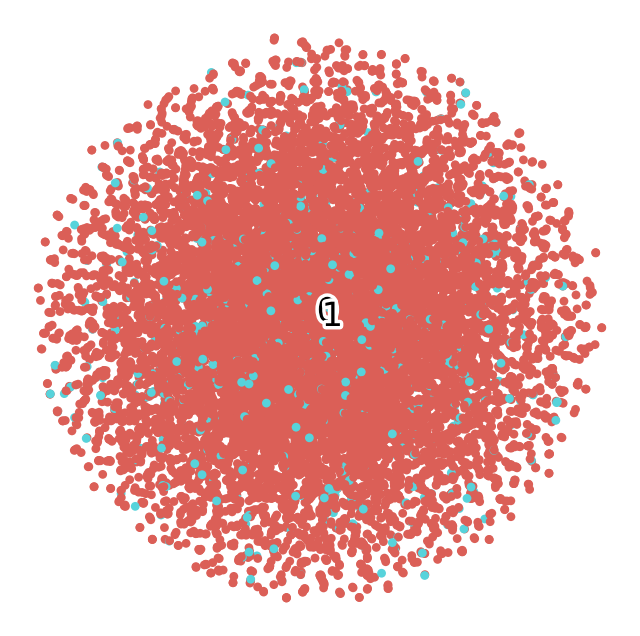

In [209]:
fashion_scatter(fashion_tsne, train_subset_df['rat'])

## create semantic network

In [70]:
train_embedded_docs

dists = euclidean_distances(train_embedded_docs,train_embedded_docs)



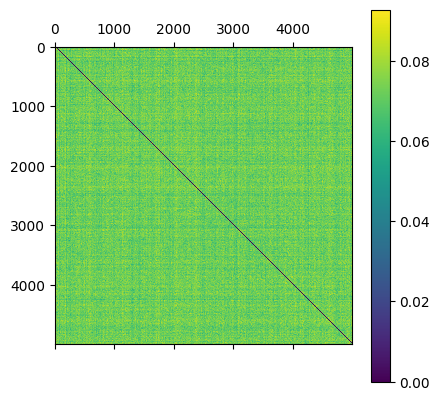

In [73]:
plt.matshow(dists)
plt.colorbar()

In [78]:
# generate a semantic simarity network
semantic_network_df = pd.DataFrame(columns=['article_id', 'outgoing_links'])
links = dists > 0.07
print(links)
semantic_network_df['article_id'] = train_subset_df['pui']
print(np.where(links == True))
semantic_network_df['outgoing_links'] = np.where(links == True)

[[False  True  True ...  True  True  True]
 [ True False  True ... False False  True]
 [ True  True False ... False False  True]
 ...
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 [ True  True  True ...  True  True False]]
(array([   0,    0,    0, ..., 4999, 4999, 4999], dtype=int64), array([   1,    2,    4, ..., 4996, 4997, 4998], dtype=int64))


ValueError: Length of values (2) does not match length of index (5000)

## KNN on d2v embeddings

In [211]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
from tqdm import tqdm

In [223]:
knn = KNeighborsClassifier(n_neighbors=25, weights='distance', n_jobs=-1)

thresholds = np.arange(0.1, 0.9, 0.2)
thresholds = [round(threshold, 2) for threshold in thresholds]
scorers = {'recall': recall_score, 'f1_score': f1_score, 'precision': precision_score}

print(thresholds)
scores = {scorer: {key: {} for key in thresholds} for scorer in scorers.keys()}
for label in tqdm(label_columns.columns):
    knn.fit(train_embedded_docs, train_subset_df[label])
    prob_preds = knn.predict_proba(val_embedded_docs)[:,1]
    
    for threshold in thresholds:
        predictions = (prob_preds >= threshold).astype(bool)
#         print(f"Confusion matrix for {label}: \n", confusion_matrix(predictions, val_subset_df[label]))
        
        for scorer_name, scorer in scorers.items():
            score = scorer(predictions, val_subset_df[label])
            print(f'{label}-{threshold:.1f}: \t \t The {scorer_name}: {score:.2f}')
            scores[scorer_name][threshold][label] = score

#     color = 'white'
#     matrix = plot_confusion_matrix(knn, embedded_docs, train_subset_df[label], cmap=plt.cm.Blues)
#     matrix.ax_.set_title('Confusion Matrix', color=color)
#     plt.xlabel('Predicted Label', color=color)
#     plt.ylabel('True Label', color=color)
#     plt.gcf().axes[0].tick_params(colors=color)
#     plt.gcf().axes[1].tick_params(colors=color)
#     plt.show()



[0.1, 0.3, 0.5, 0.7]


  2%|▉                                                  | 1/52 [00:03<03:01,  3.57s/it]

human-0.1: 	 	 The recall: 0.70
human-0.1: 	 	 The f1_score: 0.82
human-0.1: 	 	 The precision: 1.00
human-0.3: 	 	 The recall: 0.70
human-0.3: 	 	 The f1_score: 0.82
human-0.3: 	 	 The precision: 0.99
human-0.5: 	 	 The recall: 0.70
human-0.5: 	 	 The f1_score: 0.80
human-0.5: 	 	 The precision: 0.94
human-0.7: 	 	 The recall: 0.70
human-0.7: 	 	 The f1_score: 0.72
human-0.7: 	 	 The precision: 0.75


  4%|█▉                                                 | 2/52 [00:06<02:54,  3.49s/it]

controlled study-0.1: 	 	 The recall: 0.59
controlled study-0.1: 	 	 The f1_score: 0.74
controlled study-0.1: 	 	 The precision: 0.99
controlled study-0.3: 	 	 The recall: 0.59
controlled study-0.3: 	 	 The f1_score: 0.73
controlled study-0.3: 	 	 The precision: 0.94
controlled study-0.5: 	 	 The recall: 0.59
controlled study-0.5: 	 	 The f1_score: 0.67
controlled study-0.5: 	 	 The precision: 0.76
controlled study-0.7: 	 	 The recall: 0.60
controlled study-0.7: 	 	 The f1_score: 0.54
controlled study-0.7: 	 	 The precision: 0.49


  6%|██▉                                                | 3/52 [00:10<02:51,  3.49s/it]

major clinical study-0.1: 	 	 The recall: 0.29
major clinical study-0.1: 	 	 The f1_score: 0.43
major clinical study-0.1: 	 	 The precision: 0.84
major clinical study-0.3: 	 	 The recall: 0.29
major clinical study-0.3: 	 	 The f1_score: 0.40
major clinical study-0.3: 	 	 The precision: 0.67
major clinical study-0.5: 	 	 The recall: 0.27
major clinical study-0.5: 	 	 The f1_score: 0.31
major clinical study-0.5: 	 	 The precision: 0.37
major clinical study-0.7: 	 	 The recall: 0.27
major clinical study-0.7: 	 	 The f1_score: 0.18
major clinical study-0.7: 	 	 The precision: 0.13


  8%|███▉                                               | 4/52 [00:14<02:48,  3.51s/it]

clinical article-0.1: 	 	 The recall: 0.16
clinical article-0.1: 	 	 The f1_score: 0.25
clinical article-0.1: 	 	 The precision: 0.57
clinical article-0.3: 	 	 The recall: 0.15
clinical article-0.3: 	 	 The f1_score: 0.20
clinical article-0.3: 	 	 The precision: 0.30
clinical article-0.5: 	 	 The recall: 0.15
clinical article-0.5: 	 	 The f1_score: 0.13
clinical article-0.5: 	 	 The precision: 0.11
clinical article-0.7: 	 	 The recall: 0.15
clinical article-0.7: 	 	 The f1_score: 0.04
clinical article-0.7: 	 	 The precision: 0.02


 10%|████▉                                              | 5/52 [00:17<02:45,  3.53s/it]

mouse-0.1: 	 	 The recall: 0.09
mouse-0.1: 	 	 The f1_score: 0.15
mouse-0.1: 	 	 The precision: 0.36
mouse-0.3: 	 	 The recall: 0.08
mouse-0.3: 	 	 The f1_score: 0.11
mouse-0.3: 	 	 The precision: 0.18
mouse-0.5: 	 	 The recall: 0.08
mouse-0.5: 	 	 The f1_score: 0.05
mouse-0.5: 	 	 The precision: 0.04
mouse-0.7: 	 	 The recall: 0.12
mouse-0.7: 	 	 The f1_score: 0.02
mouse-0.7: 	 	 The precision: 0.01


 12%|█████▉                                             | 6/52 [00:21<02:43,  3.55s/it]

case report-0.1: 	 	 The recall: 0.06
case report-0.1: 	 	 The f1_score: 0.09
case report-0.1: 	 	 The precision: 0.24
case report-0.3: 	 	 The recall: 0.04
case report-0.3: 	 	 The f1_score: 0.04
case report-0.3: 	 	 The precision: 0.04
case report-0.5: 	 	 The recall: 0.04
case report-0.5: 	 	 The f1_score: 0.01
case report-0.5: 	 	 The precision: 0.01
case report-0.7: 	 	 The recall: 0.00
case report-0.7: 	 	 The f1_score: 0.00
case report-0.7: 	 	 The precision: 0.00


 13%|██████▊                                            | 7/52 [00:24<02:43,  3.62s/it]

rat-0.1: 	 	 The recall: 0.04
rat-0.1: 	 	 The f1_score: 0.07
rat-0.1: 	 	 The precision: 0.15
rat-0.3: 	 	 The recall: 0.05
rat-0.3: 	 	 The f1_score: 0.06
rat-0.3: 	 	 The precision: 0.07
rat-0.5: 	 	 The recall: 0.06
rat-0.5: 	 	 The f1_score: 0.01
rat-0.5: 	 	 The precision: 0.01
rat-0.7: 	 	 The recall: 0.00
rat-0.7: 	 	 The f1_score: 0.00
rat-0.7: 	 	 The precision: 0.00


 15%|███████▊                                           | 8/52 [00:28<02:39,  3.64s/it]

randomized controlled trial-0.1: 	 	 The recall: 0.04
randomized controlled trial-0.1: 	 	 The f1_score: 0.07
randomized controlled trial-0.1: 	 	 The precision: 0.19
randomized controlled trial-0.3: 	 	 The recall: 0.05
randomized controlled trial-0.3: 	 	 The f1_score: 0.07
randomized controlled trial-0.3: 	 	 The precision: 0.14
randomized controlled trial-0.5: 	 	 The recall: 0.00
randomized controlled trial-0.5: 	 	 The f1_score: 0.00
randomized controlled trial-0.5: 	 	 The precision: 0.00
randomized controlled trial-0.7: 	 	 The recall: 0.00
randomized controlled trial-0.7: 	 	 The f1_score: 0.00
randomized controlled trial-0.7: 	 	 The precision: 0.00


 17%|████████▊                                          | 9/52 [00:32<02:35,  3.63s/it]

clinical trial-0.1: 	 	 The recall: 0.03
clinical trial-0.1: 	 	 The f1_score: 0.04
clinical trial-0.1: 	 	 The precision: 0.13
clinical trial-0.3: 	 	 The recall: 0.03
clinical trial-0.3: 	 	 The f1_score: 0.04
clinical trial-0.3: 	 	 The precision: 0.09
clinical trial-0.5: 	 	 The recall: 0.00
clinical trial-0.5: 	 	 The f1_score: 0.00
clinical trial-0.5: 	 	 The precision: 0.00
clinical trial-0.7: 	 	 The recall: 0.00
clinical trial-0.7: 	 	 The f1_score: 0.00
clinical trial-0.7: 	 	 The precision: 0.00


 19%|█████████▌                                        | 10/52 [00:35<02:30,  3.58s/it]

multicenter study-0.1: 	 	 The recall: 0.02
multicenter study-0.1: 	 	 The f1_score: 0.03
multicenter study-0.1: 	 	 The precision: 0.10
multicenter study-0.3: 	 	 The recall: 0.02
multicenter study-0.3: 	 	 The f1_score: 0.03
multicenter study-0.3: 	 	 The precision: 0.06
multicenter study-0.5: 	 	 The recall: 0.00
multicenter study-0.5: 	 	 The f1_score: 0.00
multicenter study-0.5: 	 	 The precision: 0.00
multicenter study-0.7: 	 	 The recall: 0.00
multicenter study-0.7: 	 	 The f1_score: 0.00
multicenter study-0.7: 	 	 The precision: 0.00


 21%|██████████▌                                       | 11/52 [00:39<02:25,  3.55s/it]

diagnostic test accuracy study-0.1: 	 	 The recall: 0.02
diagnostic test accuracy study-0.1: 	 	 The f1_score: 0.03
diagnostic test accuracy study-0.1: 	 	 The precision: 0.08
diagnostic test accuracy study-0.3: 	 	 The recall: 0.02
diagnostic test accuracy study-0.3: 	 	 The f1_score: 0.03
diagnostic test accuracy study-0.3: 	 	 The precision: 0.05
diagnostic test accuracy study-0.5: 	 	 The recall: 0.07
diagnostic test accuracy study-0.5: 	 	 The f1_score: 0.01
diagnostic test accuracy study-0.5: 	 	 The precision: 0.01
diagnostic test accuracy study-0.7: 	 	 The recall: 0.33
diagnostic test accuracy study-0.7: 	 	 The f1_score: 0.01
diagnostic test accuracy study-0.7: 	 	 The precision: 0.01


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 23%|███████████▌                                      | 12/52 [00:42<02:21,  3.53s/it]

systematic review-0.1: 	 	 The recall: 0.02
systematic review-0.1: 	 	 The f1_score: 0.04
systematic review-0.1: 	 	 The precision: 0.11
systematic review-0.3: 	 	 The recall: 0.03
systematic review-0.3: 	 	 The f1_score: 0.03
systematic review-0.3: 	 	 The precision: 0.03
systematic review-0.5: 	 	 The recall: 0.00
systematic review-0.5: 	 	 The f1_score: 0.00
systematic review-0.5: 	 	 The precision: 0.00
systematic review-0.7: 	 	 The recall: 0.00
systematic review-0.7: 	 	 The f1_score: 0.00
systematic review-0.7: 	 	 The precision: 0.00


 25%|████████████▌                                     | 13/52 [00:46<02:16,  3.50s/it]

double blind procedure-0.1: 	 	 The recall: 0.01
double blind procedure-0.1: 	 	 The f1_score: 0.02
double blind procedure-0.1: 	 	 The precision: 0.07
double blind procedure-0.3: 	 	 The recall: 0.01
double blind procedure-0.3: 	 	 The f1_score: 0.02
double blind procedure-0.3: 	 	 The precision: 0.05
double blind procedure-0.5: 	 	 The recall: 0.00
double blind procedure-0.5: 	 	 The f1_score: 0.00
double blind procedure-0.5: 	 	 The precision: 0.00
double blind procedure-0.7: 	 	 The recall: 0.00
double blind procedure-0.7: 	 	 The f1_score: 0.00
double blind procedure-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 27%|█████████████▍                                    | 14/52 [00:49<02:12,  3.49s/it]

meta analysis-0.1: 	 	 The recall: 0.01
meta analysis-0.1: 	 	 The f1_score: 0.02
meta analysis-0.1: 	 	 The precision: 0.07
meta analysis-0.3: 	 	 The recall: 0.02
meta analysis-0.3: 	 	 The f1_score: 0.02
meta analysis-0.3: 	 	 The precision: 0.03
meta analysis-0.5: 	 	 The recall: 0.00
meta analysis-0.5: 	 	 The f1_score: 0.00
meta analysis-0.5: 	 	 The precision: 0.00
meta analysis-0.7: 	 	 The recall: 0.00
meta analysis-0.7: 	 	 The f1_score: 0.00
meta analysis-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 29%|██████████████▍                                   | 15/52 [00:53<02:09,  3.51s/it]

controlled clinical trial-0.1: 	 	 The recall: 0.01
controlled clinical trial-0.1: 	 	 The f1_score: 0.02
controlled clinical trial-0.1: 	 	 The precision: 0.06
controlled clinical trial-0.3: 	 	 The recall: 0.01
controlled clinical trial-0.3: 	 	 The f1_score: 0.02
controlled clinical trial-0.3: 	 	 The precision: 0.06
controlled clinical trial-0.5: 	 	 The recall: 0.00
controlled clinical trial-0.5: 	 	 The f1_score: 0.00
controlled clinical trial-0.5: 	 	 The precision: 0.00
controlled clinical trial-0.7: 	 	 The recall: 0.00
controlled clinical trial-0.7: 	 	 The f1_score: 0.00
controlled clinical trial-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 31%|███████████████▍                                  | 16/52 [00:56<02:05,  3.50s/it]

crossover procedure-0.1: 	 	 The recall: 0.00
crossover procedure-0.1: 	 	 The f1_score: 0.00
crossover procedure-0.1: 	 	 The precision: 0.00
crossover procedure-0.3: 	 	 The recall: 0.00
crossover procedure-0.3: 	 	 The f1_score: 0.00
crossover procedure-0.3: 	 	 The precision: 0.00
crossover procedure-0.5: 	 	 The recall: 0.00
crossover procedure-0.5: 	 	 The f1_score: 0.00
crossover procedure-0.5: 	 	 The precision: 0.00
crossover procedure-0.7: 	 	 The recall: 0.00
crossover procedure-0.7: 	 	 The f1_score: 0.00
crossover procedure-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 33%|████████████████▎                                 | 17/52 [01:00<02:01,  3.48s/it]

phase 2 clinical trial-0.1: 	 	 The recall: 0.00
phase 2 clinical trial-0.1: 	 	 The f1_score: 0.00
phase 2 clinical trial-0.1: 	 	 The precision: 0.00
phase 2 clinical trial-0.3: 	 	 The recall: 0.00
phase 2 clinical trial-0.3: 	 	 The f1_score: 0.00
phase 2 clinical trial-0.3: 	 	 The precision: 0.00
phase 2 clinical trial-0.5: 	 	 The recall: 0.00
phase 2 clinical trial-0.5: 	 	 The f1_score: 0.00
phase 2 clinical trial-0.5: 	 	 The precision: 0.00
phase 2 clinical trial-0.7: 	 	 The recall: 0.00
phase 2 clinical trial-0.7: 	 	 The f1_score: 0.00
phase 2 clinical trial-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 35%|█████████████████▎                                | 18/52 [01:03<01:58,  3.47s/it]

single blind procedure-0.1: 	 	 The recall: 0.00
single blind procedure-0.1: 	 	 The f1_score: 0.00
single blind procedure-0.1: 	 	 The precision: 0.00
single blind procedure-0.3: 	 	 The recall: 0.00
single blind procedure-0.3: 	 	 The f1_score: 0.00
single blind procedure-0.3: 	 	 The precision: 0.00
single blind procedure-0.5: 	 	 The recall: 0.00
single blind procedure-0.5: 	 	 The f1_score: 0.00
single blind procedure-0.5: 	 	 The precision: 0.00
single blind procedure-0.7: 	 	 The recall: 0.00
single blind procedure-0.7: 	 	 The f1_score: 0.00
single blind procedure-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 37%|██████████████████▎                               | 19/52 [01:06<01:54,  3.47s/it]

phase 3 clinical trial-0.1: 	 	 The recall: 0.00
phase 3 clinical trial-0.1: 	 	 The f1_score: 0.00
phase 3 clinical trial-0.1: 	 	 The precision: 0.00
phase 3 clinical trial-0.3: 	 	 The recall: 0.00
phase 3 clinical trial-0.3: 	 	 The f1_score: 0.00
phase 3 clinical trial-0.3: 	 	 The precision: 0.00
phase 3 clinical trial-0.5: 	 	 The recall: 0.00
phase 3 clinical trial-0.5: 	 	 The f1_score: 0.00
phase 3 clinical trial-0.5: 	 	 The precision: 0.00
phase 3 clinical trial-0.7: 	 	 The recall: 0.00
phase 3 clinical trial-0.7: 	 	 The f1_score: 0.00
phase 3 clinical trial-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 38%|███████████████████▏                              | 20/52 [01:10<01:50,  3.46s/it]

phase 1 clinical trial-0.1: 	 	 The recall: 0.00
phase 1 clinical trial-0.1: 	 	 The f1_score: 0.00
phase 1 clinical trial-0.1: 	 	 The precision: 0.00
phase 1 clinical trial-0.3: 	 	 The recall: 0.00
phase 1 clinical trial-0.3: 	 	 The f1_score: 0.00
phase 1 clinical trial-0.3: 	 	 The precision: 0.00
phase 1 clinical trial-0.5: 	 	 The recall: 0.00
phase 1 clinical trial-0.5: 	 	 The f1_score: 0.00
phase 1 clinical trial-0.5: 	 	 The precision: 0.00
phase 1 clinical trial-0.7: 	 	 The recall: 0.00
phase 1 clinical trial-0.7: 	 	 The f1_score: 0.00
phase 1 clinical trial-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 40%|████████████████████▏                             | 21/52 [01:13<01:47,  3.45s/it]

phase 4 clinical trial-0.1: 	 	 The recall: 0.00
phase 4 clinical trial-0.1: 	 	 The f1_score: 0.00
phase 4 clinical trial-0.1: 	 	 The precision: 0.00
phase 4 clinical trial-0.3: 	 	 The recall: 0.00
phase 4 clinical trial-0.3: 	 	 The f1_score: 0.00
phase 4 clinical trial-0.3: 	 	 The precision: 0.00
phase 4 clinical trial-0.5: 	 	 The recall: 0.00
phase 4 clinical trial-0.5: 	 	 The f1_score: 0.00
phase 4 clinical trial-0.5: 	 	 The precision: 0.00
phase 4 clinical trial-0.7: 	 	 The recall: 0.00
phase 4 clinical trial-0.7: 	 	 The f1_score: 0.00
phase 4 clinical trial-0.7: 	 	 The precision: 0.00


 42%|█████████████████████▏                            | 22/52 [01:17<01:44,  3.48s/it]

male-0.1: 	 	 The recall: 0.49
male-0.1: 	 	 The f1_score: 0.66
male-0.1: 	 	 The precision: 0.99
male-0.3: 	 	 The recall: 0.49
male-0.3: 	 	 The f1_score: 0.65
male-0.3: 	 	 The precision: 0.94
male-0.5: 	 	 The recall: 0.49
male-0.5: 	 	 The f1_score: 0.61
male-0.5: 	 	 The precision: 0.81
male-0.7: 	 	 The recall: 0.49
male-0.7: 	 	 The f1_score: 0.50
male-0.7: 	 	 The precision: 0.51


 44%|██████████████████████                            | 23/52 [01:20<01:41,  3.48s/it]

female-0.1: 	 	 The recall: 0.50
female-0.1: 	 	 The f1_score: 0.66
female-0.1: 	 	 The precision: 0.99
female-0.3: 	 	 The recall: 0.50
female-0.3: 	 	 The f1_score: 0.66
female-0.3: 	 	 The precision: 0.95
female-0.5: 	 	 The recall: 0.50
female-0.5: 	 	 The f1_score: 0.62
female-0.5: 	 	 The precision: 0.82
female-0.7: 	 	 The recall: 0.50
female-0.7: 	 	 The f1_score: 0.51
female-0.7: 	 	 The precision: 0.52


 46%|███████████████████████                           | 24/52 [01:24<01:37,  3.47s/it]

adult-0.1: 	 	 The recall: 0.42
adult-0.1: 	 	 The f1_score: 0.58
adult-0.1: 	 	 The precision: 0.96
adult-0.3: 	 	 The recall: 0.42
adult-0.3: 	 	 The f1_score: 0.56
adult-0.3: 	 	 The precision: 0.86
adult-0.5: 	 	 The recall: 0.43
adult-0.5: 	 	 The f1_score: 0.52
adult-0.5: 	 	 The precision: 0.65
adult-0.7: 	 	 The recall: 0.42
adult-0.7: 	 	 The f1_score: 0.38
adult-0.7: 	 	 The precision: 0.34


 48%|████████████████████████                          | 25/52 [01:27<01:33,  3.47s/it]

aged-0.1: 	 	 The recall: 0.18
aged-0.1: 	 	 The f1_score: 0.28
aged-0.1: 	 	 The precision: 0.66
aged-0.3: 	 	 The recall: 0.18
aged-0.3: 	 	 The f1_score: 0.25
aged-0.3: 	 	 The precision: 0.45
aged-0.5: 	 	 The recall: 0.16
aged-0.5: 	 	 The f1_score: 0.16
aged-0.5: 	 	 The precision: 0.16
aged-0.7: 	 	 The recall: 0.15
aged-0.7: 	 	 The f1_score: 0.07
aged-0.7: 	 	 The precision: 0.04


 50%|█████████████████████████                         | 26/52 [01:31<01:31,  3.50s/it]

middle aged-0.1: 	 	 The recall: 0.12
middle aged-0.1: 	 	 The f1_score: 0.19
middle aged-0.1: 	 	 The precision: 0.49
middle aged-0.3: 	 	 The recall: 0.12
middle aged-0.3: 	 	 The f1_score: 0.18
middle aged-0.3: 	 	 The precision: 0.31
middle aged-0.5: 	 	 The recall: 0.11
middle aged-0.5: 	 	 The f1_score: 0.09
middle aged-0.5: 	 	 The precision: 0.08
middle aged-0.7: 	 	 The recall: 0.10
middle aged-0.7: 	 	 The f1_score: 0.03
middle aged-0.7: 	 	 The precision: 0.02


 52%|█████████████████████████▉                        | 27/52 [01:34<01:28,  3.54s/it]

child-0.1: 	 	 The recall: 0.07
child-0.1: 	 	 The f1_score: 0.11
child-0.1: 	 	 The precision: 0.28
child-0.3: 	 	 The recall: 0.06
child-0.3: 	 	 The f1_score: 0.09
child-0.3: 	 	 The precision: 0.15
child-0.5: 	 	 The recall: 0.09
child-0.5: 	 	 The f1_score: 0.06
child-0.5: 	 	 The precision: 0.04
child-0.7: 	 	 The recall: 0.09
child-0.7: 	 	 The f1_score: 0.02
child-0.7: 	 	 The precision: 0.01


 54%|██████████████████████████▉                       | 28/52 [01:38<01:24,  3.53s/it]

adolescent-0.1: 	 	 The recall: 0.05
adolescent-0.1: 	 	 The f1_score: 0.09
adolescent-0.1: 	 	 The precision: 0.22
adolescent-0.3: 	 	 The recall: 0.06
adolescent-0.3: 	 	 The f1_score: 0.08
adolescent-0.3: 	 	 The precision: 0.15
adolescent-0.5: 	 	 The recall: 0.05
adolescent-0.5: 	 	 The f1_score: 0.03
adolescent-0.5: 	 	 The precision: 0.02
adolescent-0.7: 	 	 The recall: 0.00
adolescent-0.7: 	 	 The f1_score: 0.00
adolescent-0.7: 	 	 The precision: 0.00


 56%|███████████████████████████▉                      | 29/52 [01:41<01:20,  3.50s/it]

young adult-0.1: 	 	 The recall: 0.04
young adult-0.1: 	 	 The f1_score: 0.06
young adult-0.1: 	 	 The precision: 0.15
young adult-0.3: 	 	 The recall: 0.03
young adult-0.3: 	 	 The f1_score: 0.04
young adult-0.3: 	 	 The precision: 0.06
young adult-0.5: 	 	 The recall: 0.00
young adult-0.5: 	 	 The f1_score: 0.00
young adult-0.5: 	 	 The precision: 0.00
young adult-0.7: 	 	 The recall: 0.00
young adult-0.7: 	 	 The f1_score: 0.00
young adult-0.7: 	 	 The precision: 0.00


 58%|████████████████████████████▊                     | 30/52 [01:45<01:16,  3.49s/it]

very elderly-0.1: 	 	 The recall: 0.03
very elderly-0.1: 	 	 The f1_score: 0.05
very elderly-0.1: 	 	 The precision: 0.13
very elderly-0.3: 	 	 The recall: 0.03
very elderly-0.3: 	 	 The f1_score: 0.04
very elderly-0.3: 	 	 The precision: 0.07
very elderly-0.5: 	 	 The recall: 0.04
very elderly-0.5: 	 	 The f1_score: 0.01
very elderly-0.5: 	 	 The precision: 0.01
very elderly-0.7: 	 	 The recall: 0.00
very elderly-0.7: 	 	 The f1_score: 0.00
very elderly-0.7: 	 	 The precision: 0.00


 60%|█████████████████████████████▊                    | 31/52 [01:48<01:13,  3.50s/it]

infant-0.1: 	 	 The recall: 0.02
infant-0.1: 	 	 The f1_score: 0.04
infant-0.1: 	 	 The precision: 0.12
infant-0.3: 	 	 The recall: 0.02
infant-0.3: 	 	 The f1_score: 0.04
infant-0.3: 	 	 The precision: 0.07
infant-0.5: 	 	 The recall: 0.00
infant-0.5: 	 	 The f1_score: 0.00
infant-0.5: 	 	 The precision: 0.00
infant-0.7: 	 	 The recall: 0.00
infant-0.7: 	 	 The f1_score: 0.00
infant-0.7: 	 	 The precision: 0.00


 62%|██████████████████████████████▊                   | 32/52 [01:52<01:09,  3.48s/it]

school child-0.1: 	 	 The recall: 0.02
school child-0.1: 	 	 The f1_score: 0.03
school child-0.1: 	 	 The precision: 0.08
school child-0.3: 	 	 The recall: 0.01
school child-0.3: 	 	 The f1_score: 0.01
school child-0.3: 	 	 The precision: 0.02
school child-0.5: 	 	 The recall: 0.03
school child-0.5: 	 	 The f1_score: 0.02
school child-0.5: 	 	 The precision: 0.01
school child-0.7: 	 	 The recall: 0.00
school child-0.7: 	 	 The f1_score: 0.00
school child-0.7: 	 	 The precision: 0.00


 63%|███████████████████████████████▋                  | 33/52 [01:55<01:06,  3.49s/it]

newborn-0.1: 	 	 The recall: 0.04
newborn-0.1: 	 	 The f1_score: 0.06
newborn-0.1: 	 	 The precision: 0.16
newborn-0.3: 	 	 The recall: 0.04
newborn-0.3: 	 	 The f1_score: 0.05
newborn-0.3: 	 	 The precision: 0.09
newborn-0.5: 	 	 The recall: 0.00
newborn-0.5: 	 	 The f1_score: 0.00
newborn-0.5: 	 	 The precision: 0.00
newborn-0.7: 	 	 The recall: 0.00
newborn-0.7: 	 	 The f1_score: 0.00
newborn-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 65%|████████████████████████████████▋                 | 34/52 [01:59<01:02,  3.49s/it]

preschool child-0.1: 	 	 The recall: 0.01
preschool child-0.1: 	 	 The f1_score: 0.02
preschool child-0.1: 	 	 The precision: 0.06
preschool child-0.3: 	 	 The recall: 0.01
preschool child-0.3: 	 	 The f1_score: 0.01
preschool child-0.3: 	 	 The precision: 0.03
preschool child-0.5: 	 	 The recall: 0.00
preschool child-0.5: 	 	 The f1_score: 0.00
preschool child-0.5: 	 	 The precision: 0.00
preschool child-0.7: 	 	 The recall: 0.00
preschool child-0.7: 	 	 The f1_score: 0.00
preschool child-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 67%|█████████████████████████████████▋                | 35/52 [02:03<01:04,  3.78s/it]

embryo-0.1: 	 	 The recall: 0.02
embryo-0.1: 	 	 The f1_score: 0.03
embryo-0.1: 	 	 The precision: 0.09
embryo-0.3: 	 	 The recall: 0.02
embryo-0.3: 	 	 The f1_score: 0.03
embryo-0.3: 	 	 The precision: 0.04
embryo-0.5: 	 	 The recall: 0.00
embryo-0.5: 	 	 The f1_score: 0.00
embryo-0.5: 	 	 The precision: 0.00
embryo-0.7: 	 	 The recall: 0.00
embryo-0.7: 	 	 The f1_score: 0.00
embryo-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 69%|██████████████████████████████████▌               | 36/52 [02:07<01:01,  3.83s/it]

fetus-0.1: 	 	 The recall: 0.01
fetus-0.1: 	 	 The f1_score: 0.01
fetus-0.1: 	 	 The precision: 0.05
fetus-0.3: 	 	 The recall: 0.00
fetus-0.3: 	 	 The f1_score: 0.00
fetus-0.3: 	 	 The precision: 0.00
fetus-0.5: 	 	 The recall: 0.00
fetus-0.5: 	 	 The f1_score: 0.00
fetus-0.5: 	 	 The precision: 0.00
fetus-0.7: 	 	 The recall: 0.00
fetus-0.7: 	 	 The f1_score: 0.00
fetus-0.7: 	 	 The precision: 0.00


 71%|███████████████████████████████████▌              | 37/52 [02:12<01:01,  4.09s/it]

nonhuman-0.1: 	 	 The recall: 0.32
nonhuman-0.1: 	 	 The f1_score: 0.45
nonhuman-0.1: 	 	 The precision: 0.72
nonhuman-0.3: 	 	 The recall: 0.32
nonhuman-0.3: 	 	 The f1_score: 0.38
nonhuman-0.3: 	 	 The precision: 0.45
nonhuman-0.5: 	 	 The recall: 0.32
nonhuman-0.5: 	 	 The f1_score: 0.24
nonhuman-0.5: 	 	 The precision: 0.19
nonhuman-0.7: 	 	 The recall: 0.33
nonhuman-0.7: 	 	 The f1_score: 0.10
nonhuman-0.7: 	 	 The precision: 0.06


 73%|████████████████████████████████████▌             | 38/52 [02:17<00:59,  4.27s/it]

animal experiment-0.1: 	 	 The recall: 0.15
animal experiment-0.1: 	 	 The f1_score: 0.24
animal experiment-0.1: 	 	 The precision: 0.51
animal experiment-0.3: 	 	 The recall: 0.16
animal experiment-0.3: 	 	 The f1_score: 0.20
animal experiment-0.3: 	 	 The precision: 0.28
animal experiment-0.5: 	 	 The recall: 0.15
animal experiment-0.5: 	 	 The f1_score: 0.11
animal experiment-0.5: 	 	 The precision: 0.09
animal experiment-0.7: 	 	 The recall: 0.14
animal experiment-0.7: 	 	 The f1_score: 0.03
animal experiment-0.7: 	 	 The precision: 0.02


 75%|█████████████████████████████████████▌            | 39/52 [02:21<00:53,  4.15s/it]

animal tissue-0.1: 	 	 The recall: 0.12
animal tissue-0.1: 	 	 The f1_score: 0.18
animal tissue-0.1: 	 	 The precision: 0.39
animal tissue-0.3: 	 	 The recall: 0.12
animal tissue-0.3: 	 	 The f1_score: 0.15
animal tissue-0.3: 	 	 The precision: 0.21
animal tissue-0.5: 	 	 The recall: 0.12
animal tissue-0.5: 	 	 The f1_score: 0.08
animal tissue-0.5: 	 	 The precision: 0.05
animal tissue-0.7: 	 	 The recall: 0.07
animal tissue-0.7: 	 	 The f1_score: 0.01
animal tissue-0.7: 	 	 The precision: 0.01


 77%|██████████████████████████████████████▍           | 40/52 [02:29<01:05,  5.42s/it]

animal model-0.1: 	 	 The recall: 0.11
animal model-0.1: 	 	 The f1_score: 0.18
animal model-0.1: 	 	 The precision: 0.40
animal model-0.3: 	 	 The recall: 0.12
animal model-0.3: 	 	 The f1_score: 0.16
animal model-0.3: 	 	 The precision: 0.25
animal model-0.5: 	 	 The recall: 0.10
animal model-0.5: 	 	 The f1_score: 0.07
animal model-0.5: 	 	 The precision: 0.06
animal model-0.7: 	 	 The recall: 0.13
animal model-0.7: 	 	 The f1_score: 0.03
animal model-0.7: 	 	 The precision: 0.02


 79%|███████████████████████████████████████▍          | 41/52 [02:33<00:55,  5.03s/it]

animal cell-0.1: 	 	 The recall: 0.09
animal cell-0.1: 	 	 The f1_score: 0.14
animal cell-0.1: 	 	 The precision: 0.33
animal cell-0.3: 	 	 The recall: 0.08
animal cell-0.3: 	 	 The f1_score: 0.11
animal cell-0.3: 	 	 The precision: 0.15
animal cell-0.5: 	 	 The recall: 0.12
animal cell-0.5: 	 	 The f1_score: 0.06
animal cell-0.5: 	 	 The precision: 0.04
animal cell-0.7: 	 	 The recall: 0.21
animal cell-0.7: 	 	 The f1_score: 0.02
animal cell-0.7: 	 	 The precision: 0.01


 81%|████████████████████████████████████████▍         | 42/52 [02:37<00:48,  4.84s/it]

human cell-0.1: 	 	 The recall: 0.12
human cell-0.1: 	 	 The f1_score: 0.19
human cell-0.1: 	 	 The precision: 0.45
human cell-0.3: 	 	 The recall: 0.11
human cell-0.3: 	 	 The f1_score: 0.15
human cell-0.3: 	 	 The precision: 0.21
human cell-0.5: 	 	 The recall: 0.10
human cell-0.5: 	 	 The f1_score: 0.06
human cell-0.5: 	 	 The precision: 0.04
human cell-0.7: 	 	 The recall: 0.09
human cell-0.7: 	 	 The f1_score: 0.01
human cell-0.7: 	 	 The precision: 0.01


 83%|█████████████████████████████████████████▎        | 43/52 [02:43<00:44,  4.95s/it]

human tissue-0.1: 	 	 The recall: 0.10
human tissue-0.1: 	 	 The f1_score: 0.17
human tissue-0.1: 	 	 The precision: 0.45
human tissue-0.3: 	 	 The recall: 0.10
human tissue-0.3: 	 	 The f1_score: 0.14
human tissue-0.3: 	 	 The precision: 0.25
human tissue-0.5: 	 	 The recall: 0.08
human tissue-0.5: 	 	 The f1_score: 0.06
human tissue-0.5: 	 	 The precision: 0.05
human tissue-0.7: 	 	 The recall: 0.12
human tissue-0.7: 	 	 The f1_score: 0.03
human tissue-0.7: 	 	 The precision: 0.02


 85%|██████████████████████████████████████████▎       | 44/52 [02:47<00:38,  4.75s/it]

normal human-0.1: 	 	 The recall: 0.02
normal human-0.1: 	 	 The f1_score: 0.03
normal human-0.1: 	 	 The precision: 0.06
normal human-0.3: 	 	 The recall: 0.00
normal human-0.3: 	 	 The f1_score: 0.00
normal human-0.3: 	 	 The precision: 0.00
normal human-0.5: 	 	 The recall: 0.00
normal human-0.5: 	 	 The f1_score: 0.00
normal human-0.5: 	 	 The precision: 0.00
normal human-0.7: 	 	 The recall: 0.00
normal human-0.7: 	 	 The f1_score: 0.00
normal human-0.7: 	 	 The precision: 0.00


 87%|███████████████████████████████████████████▎      | 45/52 [02:53<00:36,  5.23s/it]

human experiment-0.1: 	 	 The recall: 0.03
human experiment-0.1: 	 	 The f1_score: 0.04
human experiment-0.1: 	 	 The precision: 0.11
human experiment-0.3: 	 	 The recall: 0.02
human experiment-0.3: 	 	 The f1_score: 0.02
human experiment-0.3: 	 	 The precision: 0.02
human experiment-0.5: 	 	 The recall: 0.00
human experiment-0.5: 	 	 The f1_score: 0.00
human experiment-0.5: 	 	 The precision: 0.00
human experiment-0.7: 	 	 The recall: 0.00
human experiment-0.7: 	 	 The f1_score: 0.00
human experiment-0.7: 	 	 The precision: 0.00


 88%|████████████████████████████████████████████▏     | 46/52 [02:58<00:30,  5.05s/it]

observational study-0.1: 	 	 The recall: 0.04
observational study-0.1: 	 	 The f1_score: 0.06
observational study-0.1: 	 	 The precision: 0.16
observational study-0.3: 	 	 The recall: 0.04
observational study-0.3: 	 	 The f1_score: 0.06
observational study-0.3: 	 	 The precision: 0.12
observational study-0.5: 	 	 The recall: 0.03
observational study-0.5: 	 	 The f1_score: 0.02
observational study-0.5: 	 	 The precision: 0.01
observational study-0.7: 	 	 The recall: 0.00
observational study-0.7: 	 	 The f1_score: 0.00
observational study-0.7: 	 	 The precision: 0.00


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 90%|█████████████████████████████████████████████▏    | 47/52 [03:03<00:25,  5.05s/it]

pilot study-0.1: 	 	 The recall: 0.02
pilot study-0.1: 	 	 The f1_score: 0.03
pilot study-0.1: 	 	 The precision: 0.10
pilot study-0.3: 	 	 The recall: 0.02
pilot study-0.3: 	 	 The f1_score: 0.03
pilot study-0.3: 	 	 The precision: 0.05
pilot study-0.5: 	 	 The recall: 0.00
pilot study-0.5: 	 	 The f1_score: 0.00
pilot study-0.5: 	 	 The precision: 0.00
pilot study-0.7: 	 	 The recall: 0.00
pilot study-0.7: 	 	 The f1_score: 0.00
pilot study-0.7: 	 	 The precision: 0.00


 92%|██████████████████████████████████████████████▏   | 48/52 [03:07<00:18,  4.71s/it]

longitudinal study-0.1: 	 	 The recall: 0.01
longitudinal study-0.1: 	 	 The f1_score: 0.02
longitudinal study-0.1: 	 	 The precision: 0.07
longitudinal study-0.3: 	 	 The recall: 0.01
longitudinal study-0.3: 	 	 The f1_score: 0.01
longitudinal study-0.3: 	 	 The precision: 0.03
longitudinal study-0.5: 	 	 The recall: 0.00
longitudinal study-0.5: 	 	 The f1_score: 0.00
longitudinal study-0.5: 	 	 The precision: 0.00
longitudinal study-0.7: 	 	 The recall: 0.00
longitudinal study-0.7: 	 	 The f1_score: 0.00
longitudinal study-0.7: 	 	 The precision: 0.00


 94%|███████████████████████████████████████████████   | 49/52 [03:10<00:13,  4.37s/it]

retrospective study-0.1: 	 	 The recall: 0.11
retrospective study-0.1: 	 	 The f1_score: 0.18
retrospective study-0.1: 	 	 The precision: 0.46
retrospective study-0.3: 	 	 The recall: 0.12
retrospective study-0.3: 	 	 The f1_score: 0.17
retrospective study-0.3: 	 	 The precision: 0.30
retrospective study-0.5: 	 	 The recall: 0.13
retrospective study-0.5: 	 	 The f1_score: 0.10
retrospective study-0.5: 	 	 The precision: 0.08
retrospective study-0.7: 	 	 The recall: 0.09
retrospective study-0.7: 	 	 The f1_score: 0.03
retrospective study-0.7: 	 	 The precision: 0.02


 96%|████████████████████████████████████████████████  | 50/52 [03:14<00:08,  4.11s/it]

case control study-0.1: 	 	 The recall: 0.03
case control study-0.1: 	 	 The f1_score: 0.04
case control study-0.1: 	 	 The precision: 0.17
case control study-0.3: 	 	 The recall: 0.02
case control study-0.3: 	 	 The f1_score: 0.03
case control study-0.3: 	 	 The precision: 0.08
case control study-0.5: 	 	 The recall: 0.00
case control study-0.5: 	 	 The f1_score: 0.00
case control study-0.5: 	 	 The precision: 0.00
case control study-0.7: 	 	 The recall: 0.00
case control study-0.7: 	 	 The f1_score: 0.00
case control study-0.7: 	 	 The precision: 0.00


 98%|█████████████████████████████████████████████████ | 51/52 [03:18<00:03,  3.95s/it]

cohort analysis-0.1: 	 	 The recall: 0.12
cohort analysis-0.1: 	 	 The f1_score: 0.19
cohort analysis-0.1: 	 	 The precision: 0.47
cohort analysis-0.3: 	 	 The recall: 0.12
cohort analysis-0.3: 	 	 The f1_score: 0.18
cohort analysis-0.3: 	 	 The precision: 0.34
cohort analysis-0.5: 	 	 The recall: 0.13
cohort analysis-0.5: 	 	 The f1_score: 0.11
cohort analysis-0.5: 	 	 The precision: 0.09
cohort analysis-0.7: 	 	 The recall: 0.14
cohort analysis-0.7: 	 	 The f1_score: 0.04
cohort analysis-0.7: 	 	 The precision: 0.03


100%|██████████████████████████████████████████████████| 52/52 [03:21<00:00,  3.88s/it]

cross-sectional study-0.1: 	 	 The recall: 0.06
cross-sectional study-0.1: 	 	 The f1_score: 0.10
cross-sectional study-0.1: 	 	 The precision: 0.27
cross-sectional study-0.3: 	 	 The recall: 0.07
cross-sectional study-0.3: 	 	 The f1_score: 0.09
cross-sectional study-0.3: 	 	 The precision: 0.14
cross-sectional study-0.5: 	 	 The recall: 0.08
cross-sectional study-0.5: 	 	 The f1_score: 0.04
cross-sectional study-0.5: 	 	 The precision: 0.02
cross-sectional study-0.7: 	 	 The recall: 0.00
cross-sectional study-0.7: 	 	 The f1_score: 0.00
cross-sectional study-0.7: 	 	 The precision: 0.00


D:\Users\bergr2\AppData\Local\Temp\ipykernel_13136\3513570183.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
D:\Users\bergr2\AppData\Local\Temp\ipykernel_13136\3513570183.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
D:\Users\bergr2\AppData\Local\Temp\ipykernel_13136\3513570183.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


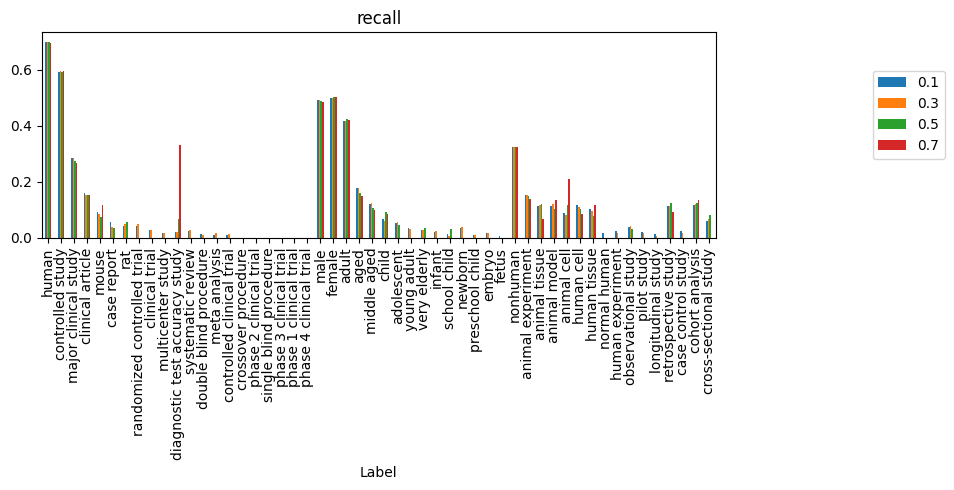

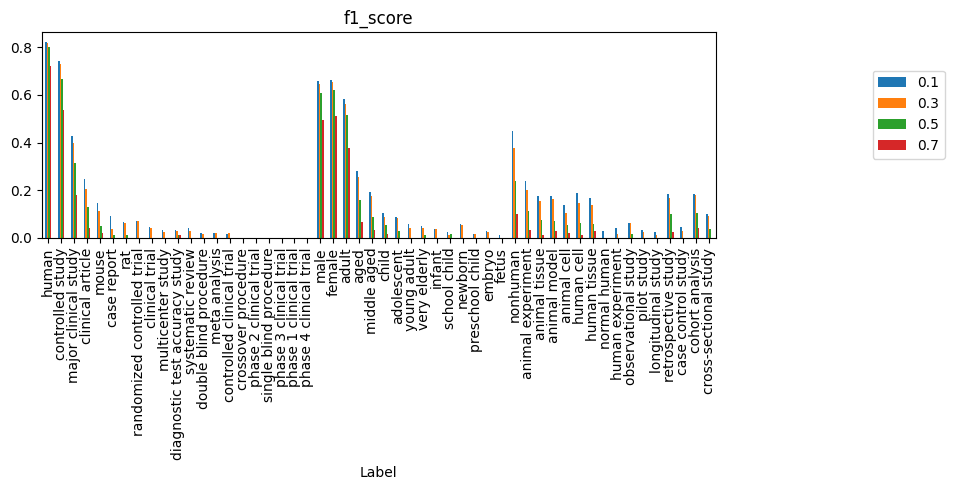

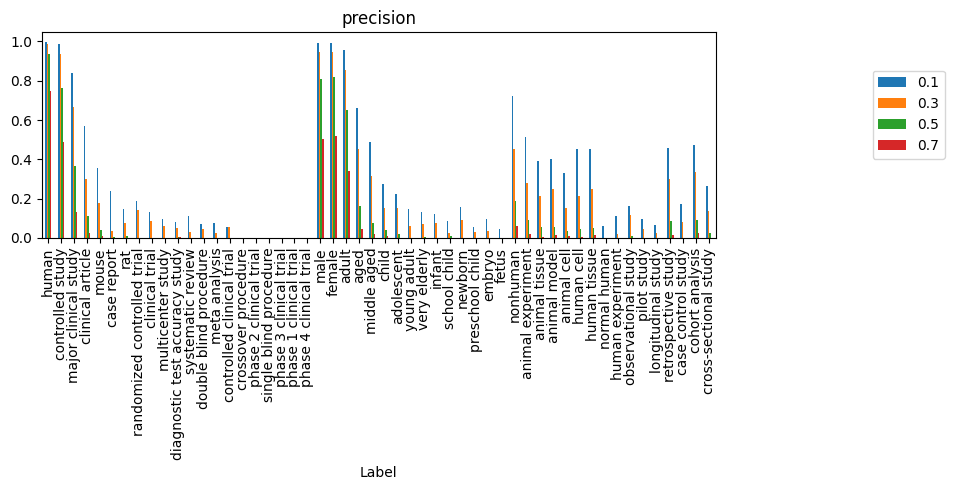

In [224]:
# check the effect of the prediction threshold on the different scores
for scorer_name, scorer in scorers.items():
    df = pd.DataFrame(list(scores[scorer_name].values()), index=list(scores[scorer_name].keys())).transpose()

    fig, ax= plt.subplots(1,1, figsize=(10,5))
    ax.set_title(f'{scorer_name}')
    df.plot.bar(ax=ax)
    ax.set_xlabel('Label')
    plt.legend(bbox_to_anchor = (1.35, 0.6), loc='center right')
    fig.tight_layout()
    fig.show()

    # plt.figure()
    # plt.title(f'{} for knn with each ')
    # plt.bar(range(len(recall_scores)), list(recall_scores.values()), align='center')
    # plt.xticks(range(len(recall_scores)), list(recall_scores.keys()), rotation=90)
    # plt.show()